In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats
from statsmodels.stats import multitest
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import Divider, Size

%config InlineBackend.figure_formats = ["svg"]
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42

def latex_sci(x):
    exp = int(np.floor(np.log10(abs(x))))
    n = x / 10**exp
    return "{:.2f}".format(n) + r" \times 10^{" + str(exp) + "}"

def asterisks(x, ns="ns"):
    if x <= 0.0001:
        return "****"
    if x <= 0.001:
        return "***"
    if x <= 0.01:
        return "**"
    if x <= 0.05:
        return "*"
    return ns

PATH_DATA = "data"
PATH_OUTPUT = "output"
if not os.path.exists(PATH_OUTPUT):
    os.mkdir(PATH_OUTPUT)

# Aggregate-enriched proteins

Read proteomics data and compute enrichment in insoluble IP as:

$$enrichment = \frac{counts_\text{99x, insoluble} + 1}{\max(counts_\text{15x, soluble}, counts_\text{99x, soluble}) + 1}$$

In [2]:
data = pd.read_excel(os.path.join(PATH_DATA, "polyGly aggregate proteomics.xlsx"))
data["enrichment"] = (data["99xGly insoluble"] + 1) / (
    data[["15xGly soluble", "15xGly insoluble"]].max(axis=1) + 1
)
data.sort_values("enrichment", ascending=False).head(10)

#                                               Name  \
2    3     ATP-dependent RNA helicase DDX1 [Homo sapiens]   
4    5    RNA-splicing ligase RtcB homolog [Homo sapiens]   
5    6  Cluster of RNA-binding protein FUS isoform 2 [...   
9   10            sequestosome-1 isoform 1 [Homo sapiens]   
0    1           polyubiquitin-B precursor [Homo sapiens]   
10  11  Cluster of ATP-dependent RNA helicase DDX3X is...   
12  13             ATPase WRNIP1 isoform 2 [Homo sapiens]   
13  14           myeloid leukemia factor 2 [Homo sapiens]   
14  15  transitional endoplasmic reticulum ATPase isof...   
17  18  Cluster of ATPase family AAA domain-containing...   

                 Refseq Gene name      MW  Protein Grouping Ambiguity  \
2           NP_004930.1      DDX1  82 kDa                         NaN   
4           NP_055121.1      RTCB  55 kDa                         NaN   
5    NP_001164105.1 [7]       FUS  53 kDa                         1.0   
9           NP_003891.1    SQSTM1  48 kDa                         NaN   
0   NP_001268649.1 (+1)       UBB  26 kDa                         NaN   
10   NP_001180345.1 [8]     DDX3X  73 kDa                         1.0   
12          NP_569079.1    WRNIP1  69 kDa                         NaN   
13          NP_005430.1      MLF2  28 kDa                         NaN   
14          NP_009057.1       VCP  89 kDa                         NaN   
17   NP_001164006.1 [3]    ATAD3A  66 kDa                         1.0   

    15xGly soluble  15xGly insoluble  99xGly soluble  99xGly insoluble  \
2                0                 0               5               579   
4                0                 0               0               332   
5                0                 0               0               249   
9                0                 0               0               157   
0               14                15              27              1968   
10               0                 0               0               110   
12               0                 0               0               105   
13               0                 0               0                93   
14               0                 0               0                91   
17               0                 0               0                90   

    enrichment  
2     580.0000  
4     333.0000  
5     250.0000  
9     158.0000  
0     123.0625  
10    111.0000  
12    106.0000  
13     94.0000  
14     92.0000  
17     91.0000

Generate list of most enriched genes (top 50 + ties):

In [3]:
cutoff = data.sort_values(by="enrichment", ascending=False).iloc[49]["enrichment"]
top_genes = data[data["enrichment"] >= cutoff]
len(top_genes)

54

In [4]:
df = data.sort_values(by="enrichment", ascending=False).drop("#", axis=1).reset_index(drop=True)
df["Protein Grouping Ambiguity"] = df["Protein Grouping Ambiguity"] == 1
df.to_excel(os.path.join(PATH_OUTPUT, "Table S1.xlsx"))

# Load gene sets and proteome sequence

In [5]:
# load gene symbol ID mapping for protein coding genes
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py

ncbi_tsv_to_py(
    os.path.join(PATH_DATA, "gene_result.txt"), "genes_ncbi_9606_proteincoding.py"
)
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt_human

nts = [nt for nt in GeneID2nt_human.values()]
sym2nt = {nt.Symbol: nt for nt in nts}
print("{N:,} gene symbols".format(N=len(sym2nt)))

# Load GO graph
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag

obo_fname = download_go_basic_obo()
obodag = GODag(obo_fname)

# load gene annotations
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader

gene2go_fname = download_ncbi_associations()
objanno = Gene2GoReader(gene2go_fname, taxids=[9606])
ns2assoc = objanno.get_ns2assc()
for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

      20,616 lines READ:  data\gene_result.txt
      20,598 geneids WROTE: genes_ncbi_9606_proteincoding.py
20,598 gene symbols
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms
  EXISTS: gene2go
HMS:0:00:02.947538 350,120 annotations, 20,728 genes, 18,978 GOs, 1 taxids READ: gene2go 
MF 18,266 annotated human genes
CC 19,761 annotated human genes
BP 18,708 annotated human genes


Sequences of all reviewed human proteins were downloaded from UniProt (03/27/2022).

In [6]:
proteome = {}
with open(
    os.path.join(PATH_DATA, "./uniprot-organism__homo+sapiens_+reviewed_yes.fasta"), "r"
) as f:
    fastas = SeqIO.parse(f, "fasta")
    for fasta in fastas:
        proteome[fasta.id] = str(fasta.seq)

accessions = set()
for p in proteome:
    accessions.add(p.split("|")[1])

print(len(proteome), "protein sequences")

20379 protein sequences


Map gene names to UniProt accessions and IDs:

In [7]:
mapping = pd.read_csv(
    os.path.join(PATH_DATA, "HUMAN_9606_idmapping.dat"),
    sep="\t",
    header=None,
    names=["Accession", "ID_type", "ID"],
)
gene2acc = mapping[
    mapping["Accession"].apply(lambda x: x in accessions)
    & (mapping["ID_type"] == "Gene_Name")
].set_index("ID")["Accession"]
acc2gene = {v: k for k, v in gene2acc.to_dict().items()}
acc2id = mapping[
    mapping["Accession"].apply(lambda x: x in accessions)
    & (mapping["ID_type"] == "UniProtKB-ID")
].set_index("Accession")["ID"]


def gene2header(gene):
    if gene not in gene2acc:
        return None
    return f"sp|{gene2acc[gene]}|{acc2id[gene2acc[gene]]}"


def acc2header(acc):
    if acc not in acc2id:
        return None
    return f"sp|{acc}|{acc2id[acc]}"


def header2gene(header):
    acc = header.split("|")[1]
    return acc2gene.get(acc, None)

# Comparisons with other datasets

How do these IP-MS data compare to similar datasets?

The Ma _et al._ dataset was generated from the `additional file 2` spreadsheet, where the listed protein name in the sheet `176 enriched inclusion proteins` was mapped to gene names for the corresponding protein group. The Kurihara _et al._ dataset was generated from table 3, where RPS27A was replaced by UBB to reflect the fact that both genes encode ubiquitin precursors.

In [8]:
top_genes_set = set(top_genes["Gene name"].to_list())
ma_dataset = {
    g
    for x in pd.read_excel(
        os.path.join(PATH_DATA, "./Ma et al. additional file 2.xlsx"),
        sheet_name="176 enriched inclusion proteins",
        header=1,
    )["Gene names"].to_list()
    for g in x.split(";")
}

kurihara_dataset = set(
    pd.read_excel(os.path.join(PATH_DATA, "./Kurihara et al. table 3.xlsx"))[
        "Gene names"
    ].to_list()
)
kurihara_dataset.remove("RPS27A")
kurihara_dataset.add("UBB")

background set: 20598 protein-coding genes


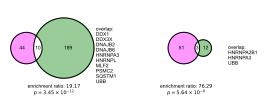

In [9]:
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import hypergeom

n_genes = len(nts)
print(f"background set: {n_genes} protein-coding genes")

fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))

for i, dataset in enumerate((ma_dataset, kurihara_dataset)):
    ax = axs[i]
    vd = venn2(
        [top_genes_set, dataset],
        set_labels=("", ""),
        ax=ax,
        normalize_to=(len(top_genes_set) + len(dataset)),
    )
    venn2_circles(
        [top_genes_set, dataset],
        linewidth=1,
        ax=ax,
        normalize_to=(len(top_genes_set) + len(dataset)),
    )

    vd.get_patch_by_id("10").set_color("magenta")
    vd.get_patch_by_id("01").set_color("green")
    vd.get_patch_by_id("11").set_color("white")

    ratio = len(top_genes_set & dataset) / len(top_genes_set) / (len(dataset) / n_genes)
    p = hypergeom.sf(
        len(top_genes_set & dataset), n_genes, len(dataset), len(top_genes_set)
    )
    ax.text(
        0.5,
        0.1,
        "enrichment ratio: ${:.2f}$\n$p=".format(ratio) + latex_sci(p) + "$",
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.95,
        0.5,
        "overlap:\n" + "\n".join(sorted(top_genes_set & dataset)),
        ha="left",
        va="center",
        transform=ax.transAxes,
    )
    ax.set_xlim((-13, 12))
    ax.set_ylim((-15, 11))

plt.tight_layout()

# IDR enrichment analysis

Are the top aggregate-enriched proteins enriched for IDRs? If so, what types of IDRs? [MobiDB-lite](https://github.com/BioComputingUP/MobiDB-lite) was then run on sequences of reviewed human proteins downloaded from Uniprot to predict IDRs.

In [10]:
region_types = [
    "Polyampholyte",
    "Positive Polyelectrolyte",
    "Negative Polyelectrolyte",
    "Proline-rich",
    "Glycine-rich",
    "Low complexity",
    "Polar",
]
feature_tag = {
    "Polyampholyte": "PA",
    "Positive Polyelectrolyte": "PPE",
    "Negative Polyelectrolyte": "NPE",
    "Proline-rich": "PR",
    "Polar": "PO",
    "Glycine-rich": "GR",
    "Low complexity": "LC",
    "Disordered": "IDR",
}

mobi = pd.read_csv(
    os.path.join(
        PATH_DATA, "./disorder_uniprot-organism__homo+sapiens_+reviewed_yes.tsv"
    ),
    sep="\t",
    header=None,
    names=["id", "start", "end", "type"],
).fillna("Disordered")

mobi.head(5)

id  start  end            type
0   sp|P51451|BLK_HUMAN      1   37      Disordered
1   sp|P51451|BLK_HUMAN      7   21   Polyampholyte
2  sp|A6H8Y1|BDP1_HUMAN      1  142      Disordered
3  sp|A6H8Y1|BDP1_HUMAN     63   77   Polyampholyte
4  sp|A6H8Y1|BDP1_HUMAN     99  119  Low complexity

Generate summary table with proteins as rows, IDR type as columns, and total number of residues in each entry.

In [11]:
mobi["length"] = mobi["end"] - mobi["start"] + 1
summary = (
    mobi[["id", "type", "length"]]
    .groupby(["id", "type"])
    .sum()
    .reset_index()
    .pivot(index="id", columns="type", values="length")
    .fillna(0)
)
summary.head(5)

type                       Disordered  Glycine-rich  Low complexity  \
id                                                                    
sp|A0A075B6H9|LV469_HUMAN        20.0           0.0             0.0   
sp|A0A075B6J9|LV218_HUMAN        33.0           0.0            15.0   
sp|A0A075B6Y9|TJA42_HUMAN        20.0           0.0             0.0   
sp|A0A087WSX0|LV545_HUMAN        25.0           0.0             0.0   
sp|A0A087WUL8|NBPFJ_HUMAN       612.0           0.0             0.0   

type                       Negative Polyelectrolyte  Polar  Polyampholyte  \
id                                                                          
sp|A0A075B6H9|LV469_HUMAN                       0.0    0.0            0.0   
sp|A0A075B6J9|LV218_HUMAN                       0.0   14.0            0.0   
sp|A0A075B6Y9|TJA42_HUMAN                       0.0    0.0            0.0   
sp|A0A087WSX0|LV545_HUMAN                       0.0   15.0            0.0   
sp|A0A087WUL8|NBPFJ_HUMAN                      23.0    0.0            0.0   

type                       Positive Polyelectrolyte  Proline-rich  
id                                                                 
sp|A0A075B6H9|LV469_HUMAN                       0.0           0.0  
sp|A0A075B6J9|LV218_HUMAN                       0.0           0.0  
sp|A0A075B6Y9|TJA42_HUMAN                       0.0           0.0  
sp|A0A087WSX0|LV545_HUMAN                       0.0           0.0  
sp|A0A087WUL8|NBPFJ_HUMAN                     266.0           0.0

Compare distributions of number of residues in each protein in a given IDR type between the top aggregate-enriched proteins versus the human proteome.

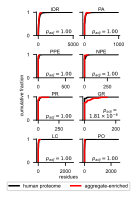

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(1.7, 2.6), sharey=True)

top_headers = set(top_genes["Gene name"].apply(gene2header)) - {None}
all_region_types = ["Disordered"] + region_types
IDR_enrichment = {}
IDR_p = {}

for i, region_type in enumerate(all_region_types):
    ax = axs[i // 2, i % 2]
    proteome_residues = list(summary[f"{region_type}"])
    aggregate_residues = list(
        map(
            lambda x: summary.loc[x][f"{region_type}"] if x in summary.index else 0,
            top_headers,
        )
    )
    IDR_enrichment[region_type] = np.log2(
        np.mean(aggregate_residues) / np.mean(proteome_residues)
    )
    IDR_p[region_type] = scipy.stats.mannwhitneyu(
        aggregate_residues, proteome_residues, alternative="greater"
    ).pvalue

    sns.ecdfplot(
        proteome_residues,
        label="human proteome" if i == 0 else "_nolegend_",
        c="k",
        ax=ax,
    )
    sns.ecdfplot(
        aggregate_residues,
        label="aggregate-enriched" if i == 0 else "_nolegend_",
        c="r",
        ax=ax,
    )
    sns.despine(ax=ax)
    ax.set_ylim((0, 1.01))
    ax.set_ylabel(None)
    ax.set_title(
        feature_tag[region_type] if i > 0 else "IDR", pad=0.2, fontdict={"fontsize": 5}
    )

IDR_padj = dict(
    zip(
        all_region_types,
        multitest.multipletests(
            [IDR_p[region_type] for region_type in all_region_types],
            method="HS",
        )[1],
    )
)
for i, region_type in enumerate(all_region_types):
    ax = axs[i // 2, i % 2]
    ax.text(
        0.95,
        0.1,
        r"$p_{adj}=" + "{:.2f}".format(IDR_padj[region_type]) + "$"
        if IDR_padj[region_type] > 0.01
        else "$p_{adj}=$\n$" + latex_sci(IDR_padj[region_type]) + "$",
        ha="right",
        transform=ax.transAxes,
    )

fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.supxlabel("residues", y=0.05, size=5)
fig.supylabel("cumulative fraction", x=0.1, size=5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.8)

Text(0, 0.5, 'cumulative fraction')

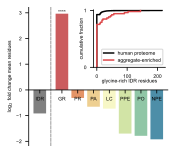

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (axl, ax) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1.4, 7.4]}, sharey=True, figsize=(2.5, 2.5)
)
inset = inset_axes(ax, width=1, height=0.8)
sns.despine()
pal = sns.color_palette("Spectral", len(region_types))

proteome_residues = list(summary["Glycine-rich"])
aggregate_residues = list(
    map(
        lambda x: summary.loc[x]["Glycine-rich"] if x in summary.index else 0,
        top_headers,
    )
)

sns.barplot(x=["IDR"], y=[IDR_enrichment["Disordered"]], color="gray", ax=axl)
axl.spines["bottom"].set_position("zero")
axl.set_ylabel(r"$\log_2$ fold change mean residues")
axl.set_xlim((-0.7, 0.7))

sns.barplot(
    x=[feature_tag[x] for x in region_types],
    y=[IDR_enrichment[x] for x in region_types],
    order=list(
        map(
            feature_tag.get,
            sorted(region_types, key=IDR_enrichment.get, reverse=True),
        )
    ),
    palette=pal,
    ax=ax,
)
for i, region_type in enumerate(
    sorted(region_types, key=IDR_enrichment.get, reverse=True)
):
    ax.text(
        i,
        IDR_enrichment[region_type],
        asterisks(IDR_padj[region_type], ns=""),
        ha="center",
    )
ax.spines["bottom"].set_position("zero")
ax.spines["left"].set_linestyle("dashed")
ax.spines["left"].set_color("gray")
ax.yaxis.set_visible(False)
ax.set_xlim((-0.7, 6.7))
plt.subplots_adjust(wspace=0)

sns.ecdfplot(proteome_residues, label="human proteome", ax=inset, c="k")
sns.ecdfplot(aggregate_residues, label="aggregate-enriched", ax=inset, c=pal[0])
inset.legend()
inset.set_ylim((0, 1.01))
inset.set_yticks([0, 1])
inset.set_xlabel("glycine-rich IDR residues", labelpad=0)
inset.set_ylabel("cumulative fraction", labelpad=0)

# Homopolymer scoring

Score each protein in the proteome according to the following algorithm:

 1. Traverse the protein sequence keeping a running score.
    a. At each position, add 1 to the running score if the residue at that position is glycine. Otherwise, subtract 1.
    b. If the running score is less than 0, set it to 0.
 2. Return the polyG score for the protein as the maximum of the running score.

This is equivalent to a Smith-Waterman local alignment, with no gaps, against an infinite sequence of polyglycine. Repeat the algorithm for all amino acids.

In [15]:
AA = list("ACDEFGHIKLMNPQRSTVWY")


def score(seq, aa="G", return_all=False):
    max_score = 0
    running_score = 0
    scores = [0]
    for s in seq:
        if s == aa:
            running_score += 1
        else:
            running_score -= 1

        if running_score > max_score:
            max_score = running_score
        elif running_score < 0:
            running_score = 0

        if return_all:
            scores.append(running_score)
    if return_all:
        return max_score, scores
    return max_score

In [16]:
scores = {}
for p, seq in proteome.items():
    for aa in AA:
        scores[p, aa] = score(seq, aa)
scores_table = pd.DataFrame(
    [[*k, v] for k, v in scores.items()], columns=["Accession", "AA", "Score"]
).pivot(index="Accession", columns="AA", values="Score")
scores_table.insert(0, "Gene Name", scores_table.index.map(header2gene))

In [17]:
scores_table.sort_values("G", ascending=False).head(10)

AA                    Gene Name   A  C  D  E  F   G  H  I  K  ...  M  N  P  Q  \
Accession                                                     ...               
sp|Q52LJ0|FA98B_HUMAN    FAM98B   2  1  2  2  1  55  1  2  3  ...  1  1  4  1   
sp|P35527|K1C9_HUMAN       KRT9   2  1  2  2  1  35  1  1  2  ...  1  2  1  1   
sp|P04264|K2C1_HUMAN       KRT1   1  1  1  2  1  32  1  2  2  ...  1  2  2  2   
sp|P13645|K1C10_HUMAN     KRT10   2  1  2  3  1  31  1  1  2  ...  1  2  1  2   
sp|P23490|LORI_HUMAN   LORICRIN   1  1  1  0  2  30  1  2  2  ...  1  0  2  2   
sp|P04632|CPNS1_HUMAN    CAPNS1   3  1  2  2  1  29  1  2  1  ...  1  2  4  1   
sp|O60902|SHOX2_HUMAN     SHOX2   6  1  2  2  1  25  3  1  2  ...  2  1  2  2   
sp|Q01851|PO4F1_HUMAN    POU4F1  14  1  1  2  1  25  9  1  2  ...  2  2  2  1   
sp|P22087|FBRL_HUMAN        FBL   3  1  2  1  1  25  1  2  2  ...  1  1  3  2   
sp|A6NHQ2|FBLL1_HUMAN     FBLL1   3  1  1  1  1  24  1  2  2  ...  1  1  1  2   

AA                     R  S  T  V  W  Y  
Accession                                
sp|Q52LJ0|FA98B_HUMAN  3  2  2  1  1  1  
sp|P35527|K1C9_HUMAN   1  4  1  1  1  2  
sp|P04264|K2C1_HUMAN   3  3  2  1  1  1  
sp|P13645|K1C10_HUMAN  2  4  2  1  1  2  
sp|P23490|LORI_HUMAN   0  2  1  1  1  1  
sp|P04632|CPNS1_HUMAN  2  2  2  2  1  1  
sp|O60902|SHOX2_HUMAN  2  2  2  2  1  1  
sp|Q01851|PO4F1_HUMAN  2  3  1  2  1  1  
sp|P22087|FBRL_HUMAN   1  1  2  3  1  1  
sp|A6NHQ2|FBLL1_HUMAN  3  3  2  3  1  1  

[10 rows x 21 columns]

In [18]:
scores_table.set_index(scores_table.index.map(lambda x: x.split("|")[1])).sort_values(
    "G", ascending=False
).to_excel(os.path.join(PATH_OUTPUT, "Table S2.xlsx"))

Illustrate scoring algorithm for two proteins.

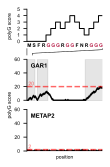

In [19]:
headers = ["sp|Q9NY12|GAR1_HUMAN", "sp|P50579|MAP2_HUMAN"]
names = ["GAR1", "METAP2"]

fig = plt.figure(figsize=(1.5, 2.153))
h = [Size.Scaled(0.7), Size.Fixed(1.05), Size.Scaled(0.3)]
v = [
    Size.Scaled(0.3),
    Size.Fixed(0.48),
    Size.Scaled(0.5),
    Size.Fixed(0.1),
    Size.Scaled(0.5),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(1.2),
][::-1]
divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
axs = [
    fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=y))
    for y in [7, 3, 1]
]

ax, header, name = axs[0], headers[0], names[0]
length = 20
regions = mobi[(mobi["id"] == header) & (mobi["type"] == "Glycine-rich")]
max_score, scores = score(proteome[header][:length], return_all=True)
sns.lineplot(
    x=range(length), y=scores[1:], ax=ax, color="k", drawstyle="steps-post", lw=1
)
ax.set_xlim((0, 15.8))
ax.set_ylim((None, 5))
ax.set_ylabel("polyG score")
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
sns.despine(bottom=True, ax=ax, trim=True)
for i, r in enumerate(proteome[header][:length]):
    ax.annotate(
        r,
        xy=(i + 0.5, 0),
        xycoords="data",
        xytext=(0, -2),
        textcoords="offset points",
        va="top",
        ha="center",
        fontweight="bold",
        c=sns.color_palette("Spectral", len(AA))[0] if r == "G" else "k",
    )

ax_space = fig.add_axes(
    divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=5)
)
ax_space.axis("off")
ax_space.set_xlim((0, 1))
ax_space.set_ylim((0, 1))
ax_space.plot([0, 0], [0, 0.9], color="k", lw=0.5, clip_on=False)
ax_space.plot(
    [16 / len(proteome[header]), 16 / len(proteome[header]), 1, 1],
    [0, 0.25, 0.75, 0.9],
    color="k",
    lw=0.5,
    clip_on=False,
)

for i, (ax, header, name) in enumerate(zip(axs[1:], headers, names)):
    length = len(proteome[header])
    regions = mobi[(mobi["id"] == header) & (mobi["type"] == "Glycine-rich")]
    max_score, scores = score(proteome[header], return_all=True)
    sns.lineplot(x=np.linspace(0, 1, length + 1), y=scores, ax=ax, color="k")

    for row in regions.itertuples():
        ax.axvspan(row.start / length, (row.end + 1) / length, color="gray", alpha=0.2)
    ax.hlines(max_score, 0, 1, color="r", linestyle="--", alpha=0.6)
    ax.text(0.02, max_score + 2, f"{max_score}", color="r", alpha=0.6)
    ax.set_xlim((0, 1))
    ax.set_ylim((None, 60))
    ax.set_yticks([0, 20, 40, 60])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    sns.despine(bottom=True, ax=ax, trim=True)
    ax.text(
        0.05,
        0.75 if i == 3 else 0.8,
        name,
        horizontalalignment="left",
        transform=ax.transAxes,
        weight="bold",
        size=6,
    )
    if i == 1:
        ax.set_xlabel("position")

ax_label = fig.add_axes(
    divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=2)
)
sns.despine(ax=ax_label, left=True, right=True, top=True, bottom=True)
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.patch.set_facecolor("none")
ax_label.set_ylabel("polyG score")
ax_label.yaxis.set_label_coords(-0.2, 0.5)

Illustrate scoring for aggregate-enriched proteins.

In [20]:
top_genes["polyG score"] = (
    top_genes["Gene name"]
    .apply(gene2header)
    .apply(lambda h: scores_table["G"].loc[h] if h is not None else np.nan)
)
data["polyG score"] = (
    data["Gene name"]
    .apply(gene2header)
    .apply(lambda h: scores_table["G"].loc[h] if h is not None else np.nan)
)

C:\Users\jason\AppData\Local\Temp\ipykernel_27004\2624892351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genes["polyG score"] = (


In [21]:
top_genes[top_genes["polyG score"] >= 10].sort_values("polyG score", ascending=False)

#                                               Name  \
32  33  Cluster of protein FAM98B [Homo sapiens] (NP_7...   
26  27  heterogeneous nuclear ribonucleoprotein A3 iso...   
5    6  Cluster of RNA-binding protein FUS isoform 2 [...   
52  53  Cluster of ATP-dependent DNA/RNA helicase DHX3...   
34  35  heterogeneous nuclear ribonucleoproteins A2/B1...   
58  59  heterogeneous nuclear ribonucleoprotein L isof...   
48  49  heterogeneous nuclear ribonucleoprotein A0 [Ho...   

                 Refseq  Gene name       MW  Protein Grouping Ambiguity  \
32      NP_775882.2 [2]     FAM98B   46 kDa                         1.0   
26  NP_001317177.1 (+3)    HNRNPA3   37 kDa                         NaN   
5    NP_001164105.1 [7]        FUS   53 kDa                         1.0   
52   NP_001107869.1 [4]      DHX36  113 kDa                         1.0   
34          NP_112533.1  HNRNPA2B1   37 kDa                         NaN   
58  NP_001372580.1 (+2)     HNRNPL   68 kDa                         1.0   
48          NP_006796.1    HNRNPA0   31 kDa                         NaN   

    15xGly soluble  15xGly insoluble  99xGly soluble  99xGly insoluble  \
32               0                 0               0                40   
26               0                 0               0                56   
5                0                 0               0               249   
52               0                 0               0                25   
34               0                 0               0                41   
58               0                 0               0                16   
48               0                 0               0                28   

    enrichment  polyG score  
32        41.0         55.0  
26        57.0         21.0  
5        250.0         16.0  
52        26.0         15.0  
34        42.0         13.0  
58        17.0         13.0  
48        29.0         11.0

Text(0, 0.5, 'polyG score')

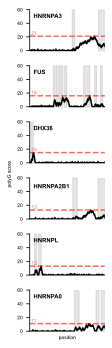

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size

fig = plt.figure(figsize=(1.5, 4.6481944444))
h = [Size.Scaled(0.7), Size.Fixed(1.05), Size.Scaled(0.3)]
v = [
    Size.Fixed(0.0250361111),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Fixed(0.1252722222),
][::-1]
divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
axs = [
    fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=y))
    for y in [11, 9, 7, 5, 3, 1]
]

names = [
    "HNRNPA3",
    "FUS",
    "DHX36",
    "HNRNPA2B1",
    "HNRNPL",
    "HNRNPA0",
]
headers = list(map(gene2header, names))

for i, (ax, header, name) in enumerate(zip(axs, headers, names)):
    length = len(proteome[header])
    regions = mobi[(mobi["id"] == header) & (mobi["type"] == "Glycine-rich")]
    max_score, scores = score(proteome[header], return_all=True)
    sns.lineplot(x=np.linspace(0, 1, length + 1), y=scores, ax=ax, color="k")

    for row in regions.itertuples():
        ax.axvspan(row.start / length, (row.end + 1) / length, color="gray", alpha=0.2)
    ax.hlines(max_score, 0, 1, color="r", linestyle="--", alpha=0.6)
    ax.text(0.02, max_score + 2, f"{max_score}", color="r", alpha=0.6)
    ax.set_xlim((0, 1))
    ax.set_ylim((None, 60))
    ax.set_yticks([0, 20, 40, 60])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    sns.despine(bottom=True, ax=ax, trim=True)
    ax.text(
        0.05,
        0.75 if i == 3 else 0.8,
        name,
        horizontalalignment="left",
        transform=ax.transAxes,
        weight="bold",
        size=6,
    )
    if i == 5:
        ax.set_xlabel("position")
fig.supylabel("polyG score", x=0, size=5)

Calculate maximum percent glycine over a window size of 100 amino acids for each protein.

In [23]:
WINDOW_SIZE = 100

percents = {}
for p, seq in proteome.items():
    seq = np.array(list(seq))
    if len(seq) < WINDOW_SIZE:
        percents[p] = None
        continue
    percents[p] = max(
        (seq[i : i + WINDOW_SIZE] == "G").mean()
        for i in range(len(seq) - WINDOW_SIZE + 1)
    )

df = scores_table.copy()
df["max_percent"] = scores_table.index.map(percents.get)
df = df.dropna()
df.sort_values("max_percent", ascending=False)

AA                         Gene Name  A  C  D  E  F   G  H  I  K  ...  N  P  \
Accession                                                         ...         
sp|Q52LJ0|FA98B_HUMAN         FAM98B  2  1  2  2  1  55  1  2  3  ...  1  4   
sp|P13645|K1C10_HUMAN          KRT10  2  1  2  3  1  31  1  1  2  ...  2  1   
sp|P35527|K1C9_HUMAN            KRT9  2  1  2  2  1  35  1  1  2  ...  2  1   
sp|P23490|LORI_HUMAN        LORICRIN  1  1  1  0  2  30  1  2  2  ...  0  2   
sp|P04264|K2C1_HUMAN            KRT1  1  1  1  2  1  32  1  2  2  ...  2  2   
...                              ... .. .. .. .. ..  .. .. .. ..  ... .. ..   
sp|P0C7W6|CC172_HUMAN        CCDC172  1  1  2  3  2   0  1  2  2  ...  2  1   
sp|Q96N35|TMM83_HUMAN      LINC00052  2  1  1  1  1   0  2  1  1  ...  1  1   
sp|A0A1B0GTR4|SPRR5_HUMAN      SPRR5  1  2  0  1  0   0  0  0  1  ...  0  3   
sp|Q9H112|CST11_HUMAN          CST11  1  1  2  1  2   0  1  1  2  ...  1  1   
sp|Q8WVK7|SKA2_HUMAN            SKA2  2  1  1  2  1   0  1  1  2  ...  1  1   

AA                         Q  R  S  T  V  W  Y  max_percent  
Accession                                                    
sp|Q52LJ0|FA98B_HUMAN      1  3  2  2  1  1  1         0.77  
sp|P13645|K1C10_HUMAN      2  2  4  2  1  1  2         0.65  
sp|P35527|K1C9_HUMAN       1  1  4  1  1  1  2         0.65  
sp|P23490|LORI_HUMAN       2  0  2  1  1  1  1         0.64  
sp|P04264|K2C1_HUMAN       2  3  3  2  1  1  1         0.60  
...                       .. .. .. .. .. .. ..          ...  
sp|P0C7W6|CC172_HUMAN      2  2  2  2  1  0  1         0.00  
sp|Q96N35|TMM83_HUMAN      1  1  2  1  1  0  1         0.00  
sp|A0A1B0GTR4|SPRR5_HUMAN  2  1  1  1  0  0  1         0.00  
sp|Q9H112|CST11_HUMAN      1  1  2  2  1  1  1         0.00  
sp|Q8WVK7|SKA2_HUMAN       1  1  1  1  1  0  1         0.00  

[19448 rows x 22 columns]

In [24]:
fig, axs = plt.subplots(
    1,
    5,
    figsize=(3, 5.5),
    sharey=False,
    gridspec_kw={"width_ratios": [1, 0.1, 1, 1, 2.1], "wspace": 0},
)

# histogram
ax_hist1, ax_hist2 = axs[0], axs[2]
ax_hist1.hist(
    scores_table["G"].values,
    bins=np.arange(59) - 0.5,
    orientation="horizontal",
    color="gray",
    rwidth=0.9,
)
ax_hist1.set_xlim((25, None))
ax_hist1.invert_xaxis()
ax_hist1.set_ylim((-0.5, 59.5))
ax_hist1.set_yticks([])
[ax_hist1.spines[k].set_visible(False) for k in ("left", "top", "right")]

ax_hist2.hist(
    scores_table["G"].values,
    bins=np.arange(0, 59) - 0.5,
    orientation="horizontal",
    color="gray",
    rwidth=0.9,
)
ax_hist2.set_xlim((0, 25))
ax_hist2.set_xticks([0, 10, 20])
ax_hist2.invert_xaxis()
ax_hist2.set_ylim((-0.5, 59.5))
ax_hist2.yaxis.tick_right()
[ax_hist2.spines[k].set_visible(False) for k in ("left", "top")]

axs[1].set_xlabel("count", labelpad=3)

# max percent gly
ax_percents = axs[4]
sns.scatterplot(
    y=df["G"], x=df["max_percent"], s=25, ax=ax_percents, color="k", alpha=0.25
)
ax_percents.set_xlim((0, 1))
ax_percents.set_xticks([0, 0.5, 1])
ax_percents.invert_xaxis()
ax_percents.set_xlabel("maximum local fraction G", labelpad=3)
ax_percents.set_ylim((-0.5, 59.5))
ax_percents.yaxis.tick_right()
ax_percents.set_ylabel("polyG score")
ax_percents.yaxis.set_label_position("right")
[ax_percents.spines[k].set_visible(False) for k in ("left", "top")]

# hide spines
for ax in (axs[1], axs[3]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

fig.align_xlabels(axs)

Illustrate glycine-rich disordered region of FAM98B using (1) DISOPRED3 disorder prediction, (2) residue visualization, and (3) polyG score.

In [25]:
disopred = []
with open(
    os.path.join(PATH_DATA, "205b7ed2-3734-11ee-97d6-00163e100d53.comb"), "r"
) as f:
    for line in f:
        line = line.strip()
        if line.startswith("#"):
            continue
        disopred.append(float(line.split(" ")[-1]))

aa_palette = {
    "D": "E60A0A",
    "E": "E60A0A",
    "C": "E6E600",
    "M": "E6E600",
    "K": "145AFF",
    "R": "145AFF",
    "S": "FA9600",
    "T": "FA9600",
    "F": "3232AA",
    "Y": "3232AA",
    "N": "00DCDC",
    "Q": "00DCDC",
    "G": "EBEBEB",
    "L": "0F820F",
    "V": "0F820F",
    "I": "0F820F",
    "A": "999999",
    "W": "B45AB4",
    "H": "8282D2",
    "P": "DC9682",
}

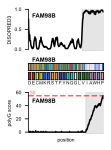

In [26]:
from mpl_toolkits.axes_grid1 import AxesGrid

header = "sp|Q52LJ0|FA98B_HUMAN"
name = "FAM98B"
length = len(proteome[header])

fig = plt.figure(figsize=(1.5, 1.9))
h = [Size.Scaled(0.7), Size.Fixed(1.05), Size.Scaled(0.3)]
v = [
    Size.Scaled(0.2),
    Size.Fixed(0.58),
    Size.Scaled(1),
    Size.Fixed(0.1),
    Size.Scaled(0.15),
    Size.Fixed(0.1),
    Size.Scaled(1),
    Size.Fixed(0.58),
    Size.Scaled(0.7),
][::-1]
divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)

ax_diso = fig.add_axes(
    divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=7)
)
diso_regions = []
diso_start = None
for i, d in enumerate(disopred + [0]):
    if d > 0.5:
        if diso_start is None:
            diso_start = i
        else:
            continue
    else:
        if diso_start is None:
            continue
        else:
            diso_regions.append((diso_start, i))
            diso_start = None
sns.lineplot(
    x=np.linspace(0, 1, length + 1), y=[None] + disopred, ax=ax_diso, color="k"
)
for reg in diso_regions:
    ax_diso.axvspan(reg[0] / length, reg[1] / length, color="gray", alpha=0.2)
ax_diso.set_xlim((0, 1))
ax_diso.set_ylim((None, 1))
ax_diso.set_yticks([0, 0.5, 1])
ax_diso.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
sns.despine(bottom=True, ax=ax_diso, trim=True)
ax_diso.text(
    0.05, 0.8, name, ha="left", transform=ax_diso.transAxes, weight="bold", size=6
)
ax_diso.set_ylabel("DISOPRED3")

ax_seq = fig.add_axes(
    divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=5)
)
for i, c in zip(
    np.linspace(0, 1, length + 1)[:-1],
    list(map(aa_palette.get, list(proteome[header]))),
):
    ax_seq.axvspan(i, i + 1 / length, color="#" + c)
ax_seq.set_xlim((0, 1))
ax_seq.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax_seq.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
ax_seq.text(
    0.05, 1.25, name, ha="left", transform=ax_seq.transAxes, weight="bold", size=6
)

ag = AxesGrid(
    fig, divider.locate(nx=1, nx1=2, ny=3, ny1=4).bounds, (1, 20), aspect=False
)
for i, (ax, (a, c)) in enumerate(zip(ag, aa_palette.items())):
    ax.set_facecolor("#" + c)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(a, y=-0.2, pad=0, va="top", size=4.5)

ax_score = fig.add_axes(
    divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
)
regions = mobi[(mobi["id"] == header) & (mobi["type"] == "Glycine-rich")]
max_score, scores = score(proteome[header], return_all=True)
sns.lineplot(x=np.linspace(0, 1, length + 1), y=scores, ax=ax_score, color="k")
for row in regions.itertuples():
    ax_score.axvspan(
        row.start / length, (row.end + 1) / length, color="gray", alpha=0.2
    )
ax_score.hlines(max_score, 0, 1, color="r", linestyle="--", alpha=0.6)
ax_score.text(0.02, max_score + 2, f"{max_score}", color="r", alpha=0.6)
ax_score.set_xlim((0, 1))
ax_score.set_ylim((None, 60))
ax_score.set_yticks([0, 20, 40, 60])
ax_score.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
sns.despine(bottom=True, ax=ax_score, trim=True)
ax_score.text(
    0.05, 0.75, name, ha="left", transform=ax_score.transAxes, weight="bold", size=6
)
ax_score.set_ylabel("polyG score")
ax_score.set_xlabel("position")

ax_diso.yaxis.set_label_coords(-0.22, 0.5)
ax_score.yaxis.set_label_coords(-0.22, 0.5)

# Homopolymer enrichment analysis

Compare distributions of polyX scores for each amino acid between the top aggregate-enriched proteins versus the human proteome.

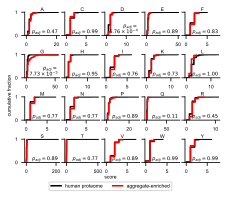

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(3.2, 2.6), sharey=True)

polyG_enrichment = {}
polyG_p = {}

for i, aa in enumerate(AA):
    ax = axs[i // 5, i % 5]
    proteome_scores = scores_table[aa].values
    aggregate_scores = list(map(lambda h: scores_table[aa].loc[h], top_headers))

    polyG_enrichment[aa] = np.log2(np.mean(aggregate_scores) / np.mean(proteome_scores))
    polyG_p[aa] = scipy.stats.mannwhitneyu(
        aggregate_scores, proteome_scores, alternative="greater"
    ).pvalue

    sns.ecdfplot(
        proteome_scores,
        label="human proteome" if i == 0 else "_nolegend_",
        ax=ax,
        c="k",
    )
    sns.ecdfplot(
        aggregate_scores,
        label="aggregate-enriched" if i == 0 else "_nolegend_",
        ax=ax,
        c="r",
    )
    sns.despine(ax=ax)
    ax.set_ylim((0, 1.01))
    ax.set_title(aa, pad=0.2, fontdict={"fontsize": 5})
    ax.set_ylabel(None)
    ax.set_xlim((None, max(8, ax.get_xlim()[1])))

polyG_padj = dict(zip(AA, multitest.multipletests([polyG_p[aa] for aa in AA], method="HS")[1]))
for i, aa in enumerate(AA):
    ax = axs[i // 5, i % 5]
    ax.text(
        0.95,
        0.1,
        r"$p_{adj}=" + "{:.2f}".format(polyG_padj[aa]) + "$"
        if polyG_padj[aa] > 0.01
        else "$p_{adj}=$\n$" + latex_sci(polyG_padj[aa]) + "$",
        ha="right",
        transform=ax.transAxes,
    )

fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    bbox_transform=fig.transFigure,
    ncol=2,
)
fig.supxlabel("score", y=0.05, size=5)
fig.supylabel("cumulative fraction", x=0.05, size=5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.8)

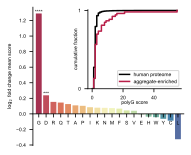

In [29]:
fig, ax = plt.subplots(figsize=(2.8, 2.5))
inset = inset_axes(ax, width=1.3, height=1.1)
sns.despine()
pal = sns.color_palette("Spectral", len(AA))

proteome_scores = scores_table["G"].values
aggregate_scores = list(map(lambda h: scores_table["G"].loc[h], top_headers))

sns.barplot(
    x=AA,
    y=[polyG_enrichment[aa] for aa in AA],
    order=sorted(AA, key=polyG_enrichment.get, reverse=True),
    palette=pal,
    ax=ax,
)
ax.set_xlim((-0.8, len(AA) - 0.2))
for i, aa in enumerate(sorted(AA, key=polyG_enrichment.get, reverse=True)):
    ax.text(i, polyG_enrichment[aa], asterisks(polyG_padj[aa], ns=""), ha="center")
ax.spines["bottom"].set_position("zero")
ax.set_ylabel(r"$\log_2$ fold change mean score")

sns.ecdfplot(proteome_scores, label="human proteome", ax=inset, c="k")
sns.ecdfplot(aggregate_scores, label="aggregate-enriched", ax=inset, c=pal[0])
inset.legend()
inset.set_ylim((0, 1.01))
inset.set_yticks([0, 1])
inset.set_xlabel("polyG score", labelpad=0)
inset.set_ylabel("cumulative fraction", labelpad=0)

plt.subplots_adjust(left=0.15)

# GO enrichment analysis

Using [GOATools](https://github.com/tanghaibao/goatools), identify GO terms enriched among the top aggregate-enriched proteins, compared to the background of the human protein-coding genome.

In [28]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
    GeneID2nt_human.keys(),
    ns2assoc,
    obodag,
    propagate_counts=True,
    alpha=0.01,
    methods=["fdr_bh"],
)


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 83% 17,022 of 20,598 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 88% 18,087 of 20,598 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 85% 17,529 of 20,598 population items found in association


In [29]:
gene_ids = [sym2nt[symbol].GeneID for symbol in top_genes["Gene name"].to_list()]
goea_results_all = goeaobj.run_study(gene_ids)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]


Runing BP Ontology Analysis: current study set of 54 IDs.
 98%     53 of     54 study items found in association
100%     54 of     54 study items found in population(20598)
Calculating 15,403 uncorrected p-values using fisher_scipy_stats
  15,403 terms are associated with 17,022 of 20,598 population items
   1,592 terms are associated with     53 of     54 study items
  METHOD fdr_bh:
     145 GO terms found significant (< 0.01=alpha) (145 enriched +   0 purified): statsmodels fdr_bh
      53 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 54 IDs.
 96%     52 of     54 study items found in association
100%     54 of     54 study items found in population(20598)
Calculating 1,985 uncorrected p-values using fisher_scipy_stats
   1,985 terms are associated with 18,087 of 20,598 population items
     247 terms are associated with     52 of     54 study items
  M

In [30]:
GO_results = []
for rec in goea_results_sig:
    GO_results.append(
        [
            rec.goterm.name,
            rec.NS,
            rec.study_count,
            rec.pop_count,
            (rec.study_count / rec.study_n) / (rec.pop_count / rec.pop_n),
            rec.p_fdr_bh,
        ]
    )
GO_results = pd.DataFrame(
    GO_results, columns=["term", "namespace", "count", "size", "ratio", "p_adj"]
)

Plot top 6 most enriched GO terms in each namespace:

In [31]:
# number of up and down GO terms to display
NUM_TERMS = 6
# GO term enrichment adjusted p value cutoff for significance
GO_P_CUTOFF = 0.01
for ns in ("MF", "CC", "BP"):
    print(ns)
    df = (
        GO_results.assign(significant=lambda x: x.p_adj < GO_P_CUTOFF)
        .query(f"namespace == '{ns}' and count > 2")
        .sort_values(["significant", "ratio"], ascending=[False, False])
        .iloc[:NUM_TERMS]
    )
    print("\n".join(df["term"].to_list()))

MF
K48-linked polyubiquitin modification-dependent protein binding
poly(A) binding
poly-purine tract binding
K63-linked polyubiquitin modification-dependent protein binding
ATPase activator activity
polyubiquitin modification-dependent protein binding
CC
tRNA-splicing ligase complex
VCP-NPL4-UFD1 AAA ATPase complex
cytoplasmic stress granule
catalytic step 2 spliceosome
ficolin-1-rich granule lumen
ribonucleoprotein granule
BP
tRNA splicing, via endonucleolytic cleavage and ligation
RNA splicing, via endonucleolytic cleavage and ligation
negative regulation of inclusion body assembly
regulation of inclusion body assembly
protein refolding
cellular response to arsenic-containing substance


In [32]:
GO_abbrev = {
    "K48-linked polyubiquitin modification-dependent protein binding": "K48-linked polyubiquitin-dependent binding",
    "K63-linked polyubiquitin modification-dependent protein binding": "K63-linked polyubiquitin-dependent binding",
    "polyubiquitin modification-dependent protein binding": "polyubiquitin-dependent protein binding",
    "tRNA splicing, via endonucleolytic cleavage and ligation": "tRNA splicing, via cleavage and ligation",
    "RNA splicing, via endonucleolytic cleavage and ligation": "RNA splicing, via cleavage and ligation",
    "negative regulation of inclusion body assembly": "neg. regulation of inclusion body assembly",
    "positive regulation of proteasomal ubiquitin-dependent protein catabolic process": "pos. regulation of proteasomal protein catabolism",
    "cellular response to arsenic-containing substance": "response to arsenic-containing substance"
}

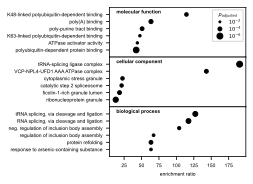

In [33]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3.5, 2.5))
namespaces = {
    "MF": "molecular function",
    "CC": "cellular component",
    "BP": "biological process",
}

for ax, ns in zip(axs, ("MF", "CC", "BP")):
    df = (
        GO_results.assign(significant=lambda x: x.p_adj < GO_P_CUTOFF)
        .query(f"namespace == '{ns}' and count > 2")
        .sort_values(["significant", "ratio"], ascending=[False, False])
        .iloc[:NUM_TERMS]
    )
    for i, row in enumerate(df.itertuples()):
        ax.plot([row.ratio], [-i], "ko", ms=-np.log10(row.p_adj))
    ax.set_ylim((-NUM_TERMS, 1))
    ax.set_yticks(
        range(0, -NUM_TERMS, -1),
        [GO_abbrev[x] if x in GO_abbrev else x for x in df["term"].to_list()],
    )
    ax.yaxis.set_tick_params(labelsize=5)
    ax.text(
        0.05,
        0.95,
        namespaces[ns],
        ha="left",
        va="top",
        transform=ax.transAxes,
        weight="bold",
    )

ax.set_xlabel("enrichment ratio")
axs[0].legend(
    handles=[
        Line2D(
            [0],
            [0],
            lw=0,
            marker="o",
            color="k",
            ms=-np.log10(10**-2),
            label="$10^{-2}$",
        ),
        Line2D(
            [0],
            [0],
            lw=0,
            marker="o",
            color="k",
            ms=-np.log10(10**-4),
            label="$10^{-4}$",
        ),
        Line2D(
            [0],
            [0],
            lw=0,
            marker="o",
            color="k",
            ms=-np.log10(10**-6),
            label="$10^{-6}$",
        ),
    ],
    title="$p_{adjusted}$",
    bbox_to_anchor=(0.98, 0.95),
    borderpad=0.5,
    borderaxespad=0,
    loc="upper right",
)
plt.tight_layout()
plt.subplots_adjust(hspace=0)

# Session info

In [34]:
import session_info

session_info.show()